# Movies recommendation system

https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

We will try to make a film recommendation system. However, due to the fact that the full dataset containing information about movies from imdb has a size of about 7.5 GB, we will use a truncated version of the dataset containing only the top 1000 movies from imdb.

In [2]:
!pip install kagglehub

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows/versions/1


In [34]:
df = pd.read_csv(path + "/imdb_top_1000.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [30]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


* **Poster_Link** - Link of the poster that imdb using
* **Series_Title** = Name of the movie
* **Released_Year** - Year at which that movie released
* **Certificate** - Certificate earned by that movie
* **Runtime** - Total runtime of the movie
* **Genre** - Genre of the movie
* **IMDB_Rating** - Rating of the movie at IMDB site
* **Overview** - mini story/ summary
* **Meta_score** - Score earned by the movie
* **Director** - Name of the Director
* **Star1,Star2,Star3,Star4** - Name of the Stars
* **No_of_votes** - Total number of votes
* **Gross** - Money earned by that movie

# Data cleaning

In [31]:
df.drop(['Poster_Link'], axis=1, inplace=True)

We remove unnecessary columns, in the case of our project, the column containing a link to the movie poster does not add any value in the creation of the recommender system

In [32]:
df[df.duplicated()]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross


We check the dataset for duplicates. As it turns out, it does not contain any duplicate records.

In [33]:
print(df.isnull().sum())

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


In our dataset we have missing in the Certificate, Meta_Score and No_of_Votes columns. This data will be crucial in setting up our recommendation system. To do this, we will replace the empty Meta_Score values with the average meta score value, replace the empty 'Certificate' with the most common value.

In [39]:
%%capture
df['Meta_score'].fillna(df['Meta_score'].mean(), inplace=True)

In [40]:
%%capture
df['Certificate'].fillna(df['Certificate'].mode()[0], inplace=True)

Gross values are given in string form. We will convert them to int and get rid of the missing values, inserting average values in their place.

In [36]:
def gross_to_int(value):
  if isinstance(value, str):
    value = int(value.replace(",", ""))
  return value

df['Gross'] = df['Gross'].apply(gross_to_int)

In [37]:
%%capture
df['Gross'].fillna(df['Gross'].mean(), inplace=True)

In [41]:
print(df.isnull().sum())

Poster_Link      0
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64


# Data exploration

In [42]:
df.describe()

,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.00000,1.000000e+03,1.000000e+03
mean,7.949300,77.97153,2.736929e+05,6.803475e+07
std,0.275491,11.36206,3.273727e+05,1.000371e+08
min,7.600000,28.00000,2.508800e+04,1.305000e+03
25%,7.700000,72.00000,5.552625e+04,5.012919e+06
50%,7.900000,77.97153,1.385485e+05,4.238945e+07
75%,8.100000,85.25000,3.741612e+05,6.803475e+07
max,9.300000,100.00000,2.343110e+06,9.366622e+08


The average rating of the film on IMDB is 7.9 on Metacritic this value is 77.97.
The average number of votes is 273,692 and the average earnings of the film is 6,8034,750.

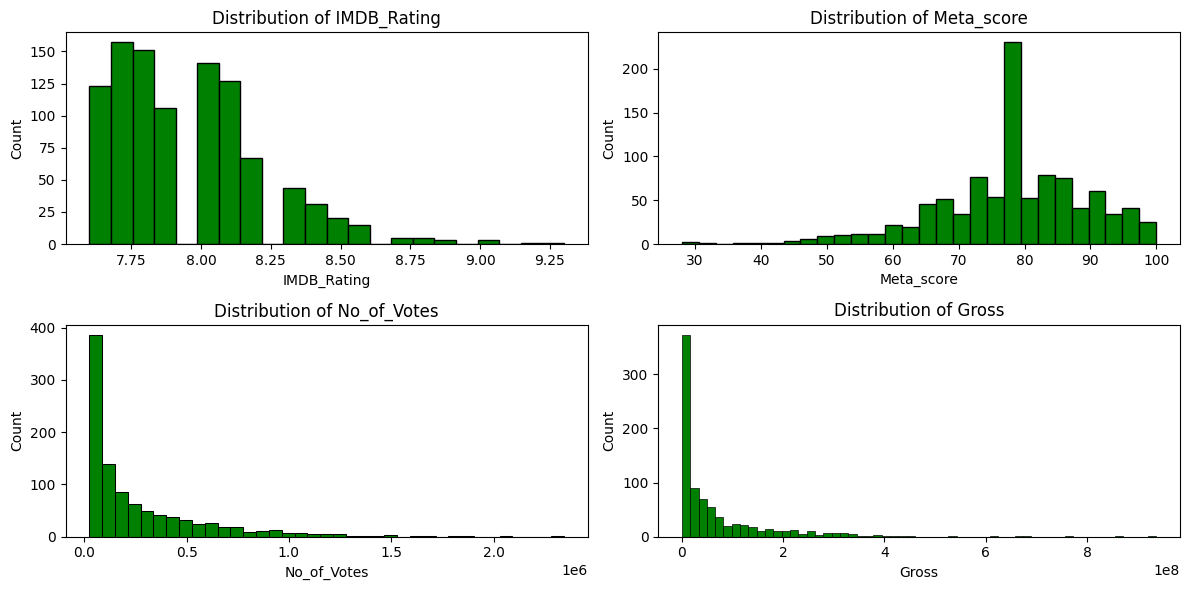

In [15]:
coulmns = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross"]
n_cols = 2
n_rows = (len(coulmns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))

axes = axes.flatten()

for i, col in enumerate(coulmns):
    sns.histplot(df[col], ax=axes[i], color='g', alpha=1)
    axes[i].set_title(f'Distribution of {col}')

for i in range(len(coulmns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<ipython-input-35-24b8f74885bb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df['Certificate'],palette='pastel')


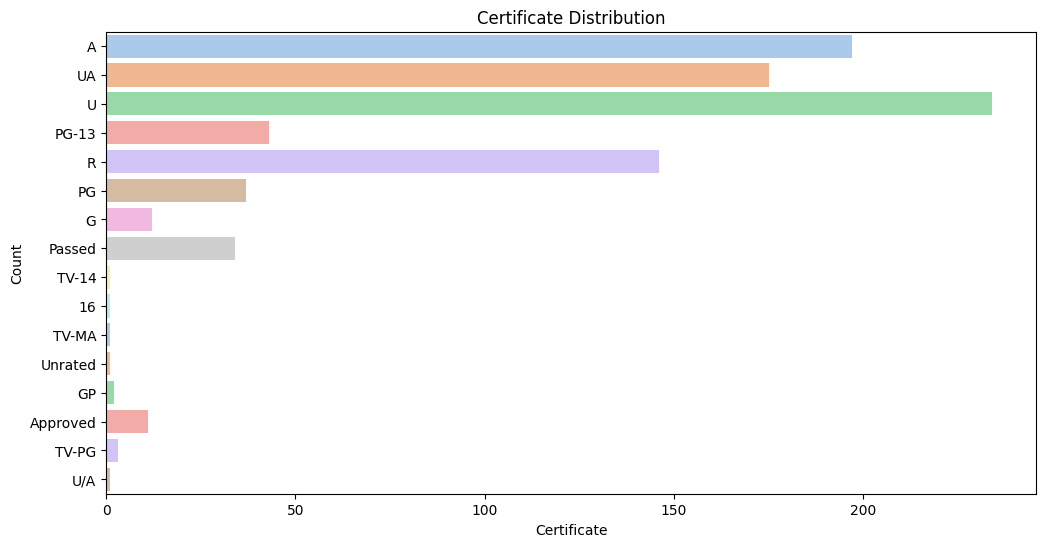

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(df['Certificate'],palette='pastel')
plt.title('Certificate Distribution')
plt.xlabel('Certificate')
plt.ylabel('Count')
plt.show()

This distribution shows us which film certificates are most popular. The largest number of films we have are 'U' films that are suitable for any age group. In second place we have 'A' meaning restricted to adults, and in third place we have 'UA' meaning unrestricted public exhibition, but with mandatory age-restricted parental guidance. It is worth noting that each country has its own film certification system and the dataset used a mix of several systems. The most common categories are from the Indian system and categories such as R, G are specific to the United States system/.

In [17]:
genre_ratings = df.groupby('Genre')['IMDB_Rating'].mean().sort_values(ascending=False)
genre_ratings

,IMDB_Rating
Genre,
"Animation, Drama, War",8.50
"Drama, Musical",8.40
"Action, Sci-Fi",8.40
"Drama, Mystery, War",8.35
Western,8.35
...,...
"Adventure, Comedy, War",7.60
"Animation, Comedy, Crime",7.60
"Action, Adventure, Family",7.60


The best rated films are a mix of the genres 'Animation, Drama, War' and the least rated are a mix of the genres 'Action', 'Adventure', 'Mystery'

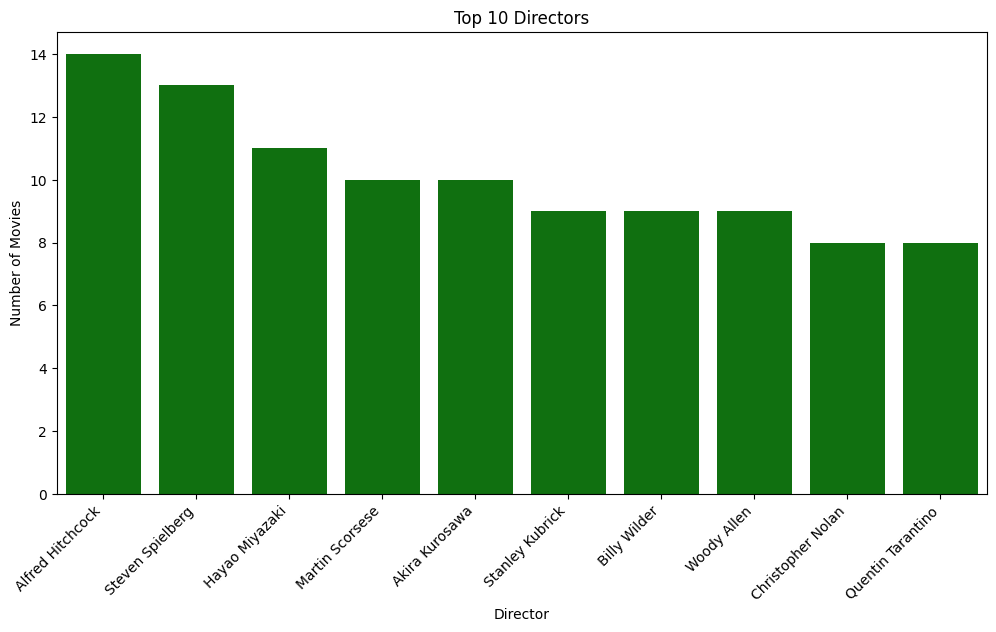

In [93]:
plt.figure(figsize=(12, 6))
directors = df['Director'].value_counts().nlargest(10).index
top_directors = df[df['Director'].isin(directors)]['Director']
sns.countplot(x=top_directors, order=directors,
              color='g')
plt.title('Top 10 Directors')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

We checked which directors created the most films falling into the top 1000 rated movies category.

In [103]:

top_directors = df['Director'].value_counts().nlargest(10).index
top_directors_df = df[df['Director'].isin(top_directors)]
gross_sum_by_director = top_directors_df.groupby('Director')['Gross'].sum()
gross_sum_by_director = gross_sum_by_director.reset_index()

pd.reset_option('display.float_format')

gross_sum_by_director.sort_values(by='Gross', ascending=False)

,Director,Gross
8,Steven Spielberg,2.478133e+09
3,Christopher Nolan,1.937454e+09
6,Quentin Tarantino,7.270343e+08
5,Martin Scorsese,5.383192e+08
1,Alfred Hitchcock,4.592832e+08
0,Akira Kurosawa,4.127651e+08
7,Stanley Kubrick,3.879179e+08
9,Woody Allen,3.136100e+08
4,Hayao Miyazaki,3.111826e+08
2,Billy Wilder,2.750291e+08


Despite being second in the number of films that hit the top 1000 Steven Spielberg is first when it comes to the box office success of his productions. His films earned 2,478,133,000. Of the top 10 directors, Billy Wilder's films generated the least revenue (275,021,910).

# Content-Based Recommendation System

Content-based systems recommend items to the customer similar to previously high-rated items by the customer. It uses the features and properties of the item. From these properties, it can calculate the similarity between the items.

In [107]:
tfidf = TfidfVectorizer(stop_words='english')


df['commbined_features'] = df['Genre'] + ' ' + df['Director'] + ' ' + \
  df['Star1'] + ' ' + df['Star2'] + ' ' + df['Star3'] + ' ' + df['Star4'] + ' ' + df['Overview']

tfidf_matrix = tfidf.fit_transform(df['commbined_features'])
tfidf_matrix.shape

(1000, 9390)

We will base our recommendation on a combination of features: Genre, Director, Star1, Star2, Star3, Star4 and movie overview

In [20]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Now we use cosine similarity. This metric quantifies the similarity between two vectors by calculating the cosine of the angle between them. In this case, it's used to compare the feature vectors of different movies. A higher cosine similarity indicates a greater resemblance between the movies.

In [21]:
def get_recommendations(title, cosine_sim=cosine_sim, data=df, num_recommendations=10):
    idx = data[data['Series_Title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]

    recommendations = data.iloc[sim_indices][['Series_Title', 'IMDB_Rating',
                                              'Genre', 'Director',
                                              'Certificate']].reset_index(drop=True)

    return recommendations

This function, get_recommendations, identifies and returns a list of TV series recommendations based on a given input series title. It leverages cosine similarity scores calculated from a dataset of series information to find the most similar series and present them with relevant metadata like IMDB rating, genre, director, and certificate.

In [108]:
get_recommendations('Reservoir Dogs')

,Series_Title,IMDB_Rating,Genre,Director,Certificate
0,Kill Bill: Vol. 1,8.1,"Action, Crime, Drama",Quentin Tarantino,R
1,Kill Bill: Vol. 2,8.0,"Action, Crime, Thriller",Quentin Tarantino,A
2,The Irishman,7.9,"Biography, Crime, Drama",Martin Scorsese,R
3,Inglourious Basterds,8.3,"Adventure, Drama, War",Quentin Tarantino,A
4,Dog Day Afternoon,8.0,"Biography, Crime, Drama",Sidney Lumet,U
5,Heat,8.2,"Crime, Drama, Thriller",Michael Mann,A
6,Sin City,8.0,"Crime, Thriller",Frank Miller,A
7,Mystic River,7.9,"Crime, Drama, Mystery",Clint Eastwood,A
8,Pulp Fiction,8.9,"Crime, Drama",Quentin Tarantino,A
9,M - Eine Stadt sucht einen Mörder,8.3,"Crime, Mystery, Thriller",Fritz Lang,Passed


As you can see, we get as many as 4 films from the same director. The rest of the recommendations make sense with our film, we get crime dramas whose titles and plot are similar to Reservoir Dogs

### User favourite list

We will now try to get recommendations based on the list of movies liked by the user. For each title in the list, we will call the get_recommendations function and select the highest rated movie from the resulting list.

In [24]:
def get_user_recommendations(user_list, cosine_sim=cosine_sim, data=df, num_recommendations=10):
  user_recommendations = []

  for favorite_title in user_list:
    reccomendations = get_recommendations(
        title=favorite_title,
          cosine_sim=cosine_sim,
          data=data,
          num_recommendations=num_recommendations
      )
    highest_rated = reccomendations.loc[reccomendations['IMDB_Rating'].idxmax()]
    user_recommendations.append({
        "User Favourite": favorite_title,
        "Recommended Title": highest_rated['Series_Title'],
        "IMDB Rating": highest_rated['IMDB_Rating']
    })

  return pd.DataFrame(user_recommendations)

In [27]:
user_favorite_list = ['Reservoir Dogs', 'The Lord of the Rings: The Two Towers',
                      'The Godfather', 'A Beautiful Mind', 'Forrest Gump']
get_user_recommendations(user_favorite_list)

,User Favourite,Recommended Title,IMDB Rating
0,Reservoir Dogs,Pulp Fiction,8.9
1,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Return of the King,8.9
2,The Godfather,The Godfather: Part II,9.0
3,A Beautiful Mind,The Truman Show,8.1
4,Forrest Gump,Saving Private Ryan,8.6


We can see that our results seem reasonable. The case of Reservoir Dogs has already been discussed by us. In the case of the other films, we recommended sequels, or films from the same universe. A Beautiful Mind and The Truman Show tell the story of a man facing the problem of recognizing what is true and what is false. Forrest Gump and Saving Private Ryan have the same leading star.

# Collaborative Filtering

Collaborative filtering is based on the idea that similar people (based on the data) generally tend to like similar things. It predicts which item a user will like based on the item preferences of other similar users.

In [129]:
scaler = MinMaxScaler()
df['normalized_votes'] = scaler.fit_transform(df[['No_of_Votes']])
df['normalized_rating'] = scaler.fit_transform(df[['IMDB_Rating']])
df['normalized_gross'] = scaler.fit_transform(df[['Gross']])

df['interaction_score'] = df['normalized_votes'] * 0.4 + 0.3 * df['normalized_rating'] + 0.3 * df['normalized_gross']

And in the case of Collaborative Filtering, we need information about the choices of other users. We don't have such information included in our DataSet but we will try to use the number of user ratings, video rating and revenue to create implicit user-like interactions

In [130]:
interaction_matrix = np.dot(
    np.array([df['interaction_score']]).T,
    np.array([df['interaction_score']])
)

np.fill_diagonal(interaction_matrix, 0)

interaction_df = pd.DataFrame(interaction_matrix, index=df['Series_Title'],
                              columns=df['Series_Title'])
interaction_df.head()

Series_Title,The Shawshank Redemption,The Godfather,The Dark Knight,The Godfather: Part II,12 Angry Men,The Lord of the Rings: The Return of the King,Pulp Fiction,Schindler's List,Inception,Fight Club,...,Giù la testa,Kelly's Heroes,The Jungle Book,Blowup,A Hard Day's Night,Breakfast at Tiffany's,Giant,From Here to Eternity,Lifeboat,The 39 Steps
Series_Title,,,,,,,,,,,,,,,,,,,,,
The Shawshank Redemption,0.000000,0.426058,0.575405,0.323387,0.257513,0.446419,0.407563,0.330090,0.466455,0.382441,...,0.000777,0.002791,0.049505,0.019296,0.004997,0.032759,0.016551,0.009164,0.015620,0.018726
The Godfather,0.426058,0.000000,0.487592,0.274034,0.218213,0.378290,0.345364,0.279715,0.395268,0.324076,...,0.000658,0.002365,0.041950,0.016351,0.004234,0.027760,0.014025,0.007765,0.013236,0.015868
The Dark Knight,0.575405,0.487592,0.000000,0.370092,0.294704,0.510892,0.466425,0.377763,0.533822,0.437675,...,0.000889,0.003194,0.056655,0.022083,0.005718,0.037491,0.018941,0.010487,0.017876,0.021430
The Godfather: Part II,0.323387,0.274034,0.370092,0.000000,0.165628,0.287129,0.262138,0.212309,0.300016,0.245980,...,0.000499,0.001795,0.031841,0.012411,0.003214,0.021070,0.010645,0.005894,0.010047,0.012044
12 Angry Men,0.257513,0.218213,0.294704,0.165628,0.000000,0.228641,0.208740,0.169061,0.238903,0.195874,...,0.000398,0.001429,0.025355,0.009883,0.002559,0.016778,0.008477,0.004693,0.008000,0.009591


We create a similarity matrix (mimicking user-item interactions)

In [131]:
U, sigma, Vt = svds(interaction_matrix, k=2)
sigma = np.diag(sigma)

predicted_matrix = np.dot(np.dot(U, sigma), Vt)
predicted_df = pd.DataFrame(predicted_matrix, index=df['Series_Title'],
                         columns=df['Series_Title'])
predicted_df.head()

Series_Title,The Shawshank Redemption,The Godfather,The Dark Knight,The Godfather: Part II,12 Angry Men,The Lord of the Rings: The Return of the King,Pulp Fiction,Schindler's List,Inception,Fight Club,...,Giù la testa,Kelly's Heroes,The Jungle Book,Blowup,A Hard Day's Night,Breakfast at Tiffany's,Giant,From Here to Eternity,Lifeboat,The 39 Steps
Series_Title,,,,,,,,,,,,,,,,,,,,,
The Shawshank Redemption,0.484378,0.413798,0.597574,0.316161,0.252530,0.432834,0.396390,0.322600,0.451402,0.372603,...,0.000765,0.002751,0.048789,0.019020,0.004925,0.032289,0.016314,0.009033,0.015397,0.018458
The Godfather,0.413798,0.352972,0.490739,0.269543,0.215263,0.369289,0.338073,0.275038,0.385245,0.317736,...,0.000652,0.002344,0.041582,0.016210,0.004198,0.027519,0.013904,0.007699,0.013122,0.015731
The Dark Knight,0.597574,0.490739,0.001674,0.369609,0.294045,0.516273,0.468234,0.377342,0.542663,0.438328,...,0.000887,0.003188,0.056551,0.022043,0.005708,0.037422,0.018907,0.010469,0.017844,0.021392
The Godfather: Part II,0.316161,0.269543,0.369609,0.205795,0.164344,0.282025,0.258152,0.209992,0.294241,0.242610,...,0.000498,0.001790,0.031744,0.012375,0.003205,0.021008,0.010614,0.005877,0.010018,0.012009
12 Angry Men,0.252530,0.215263,0.294045,0.164344,0.131239,0.225236,0.206163,0.167696,0.234999,0.193748,...,0.000398,0.001429,0.025349,0.009882,0.002559,0.016776,0.008476,0.004693,0.008000,0.009590


Now we use SVD to reduce the dimensionality of the interaction matrix, uncover latent factors that explain patterns in preferences, and predict missing interactions.

In [132]:
def recommend_movies(movie_title, predicted_df, num_recommendations=10):
    scores = predicted_df[movie_title].sort_values(ascending=False)
    return scores.iloc[1:num_recommendations+1]


recommend_movies('A Beautiful Mind', predicted_df)

,A Beautiful Mind
Series_Title,
The Shawshank Redemption,0.210839
Inception,0.196195
The Lord of the Rings: The Return of the King,0.188042
Forrest Gump,0.186836
The Godfather,0.179714
The Lord of the Rings: The Fellowship of the Ring,0.178069
Pulp Fiction,0.172116
The Lord of the Rings: The Two Towers,0.166584
Avengers: Endgame,0.165321


As you can see, this solution does not give satisfactory results. Some of the recommended films seem reasonable, but there were items in the list that differ significantly from our film.